In [11]:
import pandas as pd 
import nltk,re,time,umap,collections,os,string,sys,mlflow,glob
sys.path.append(os.path.abspath(".."))
from modules import utils,modeling

from sentence_transformers import SentenceTransformer,util
import plotly.express as px
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual

from sklearn.metrics.pairwise import cosine_distances

from sklearn.metrics import completeness_score,homogeneity_score, v_measure_score,normalized_mutual_info_score,adjusted_mutual_info_score,silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from summa.summarizer import summarize
from summa.keywords import keywords
from hdbscan import HDBSCAN
from sentence_transformers import models
from sklearn.preprocessing import normalize
from torch import nn
import mlflow.sklearn
from  mlflow.tracking import MlflowClient
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from textwrap import wrap
stopwords = utils.load_stopwords()


remote_server="http://ec2-18-193-70-141.eu-central-1.compute.amazonaws.com"
client = MlflowClient(remote_server)
mlflow.set_tracking_uri(remote_server)


%matplotlib inline
%load_ext autoreload
%autoreload 2

%reload_ext utils
%reload_ext modeling
os.environ["MLFLOW_S3_ENDPOINT_URL"]="http://s3.eu-central-1.amazonaws.com"
os.environ["MLFLOW_TRACKING_USERNAME"]="mlflow"
os.environ["MLFLOW_TRACKING_PASSWORD"]="mlflow"

/Users/ttkaczyk/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:172: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/Users/ttkaczyk/opt/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1

Number of stopwords 607


In [12]:
d=pd.read_csv('~/Desktop/input_bild_OCT_DEC_SAFE.csv',engine='python',sep=';',error_bad_lines=False)

Skipping line 11: field larger than field limit (131072)
Skipping line 51: field larger than field limit (131072)
Skipping line 152: field larger than field limit (131072)
Skipping line 2166: field larger than field limit (131072)
Skipping line 3135: field larger than field limit (131072)
Skipping line 4783: field larger than field limit (131072)
Skipping line 5784: field larger than field limit (131072)
Skipping line 7560: field larger than field limit (131072)
Skipping line 9623: field larger than field limit (131072)
Skipping line 11467: field larger than field limit (131072)
Skipping line 13015: field larger than field limit (131072)
Skipping line 13508: field larger than field limit (131072)
Skipping line 13973: field larger than field limit (131072)
Skipping line 14316: field larger than field limit (131072)
Skipping line 14796: field larger than field limit (131072)
Skipping line 15211: field larger than field limit (131072)
Skipping line 16213: field larger than field limit (13

In [13]:
d.created_at =pd.to_datetime(d.created_at)

In [14]:
d.created_at.min(),d.created_at.max()

(Timestamp('2020-07-01 00:01:08'), Timestamp('2020-12-31 21:54:16'))

In [15]:
d = d.set_index('article_uid')
d.shape

(32882, 9)

In [16]:
d =d.drop_duplicates(subset=['cms_id'])
d.shape

(32814, 9)

In [17]:
d = d[(d.department != 'ratgeber') & (d.created_at > '2020-08-01')]
d.shape

(25414, 9)

<AxesSubplot:>

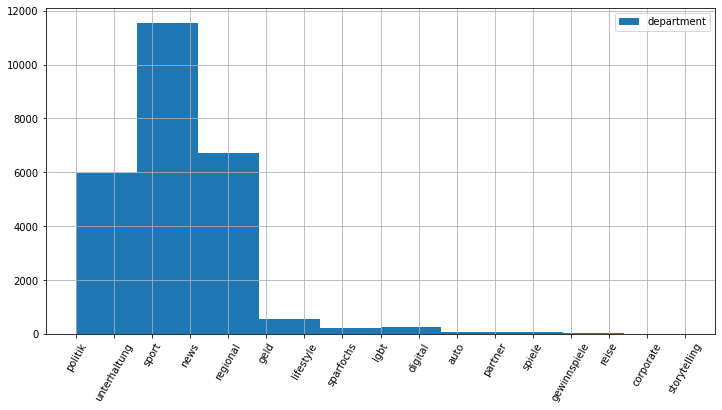

In [56]:
d.department.hist(figsize=(12,6),xrot=60,legend=True)

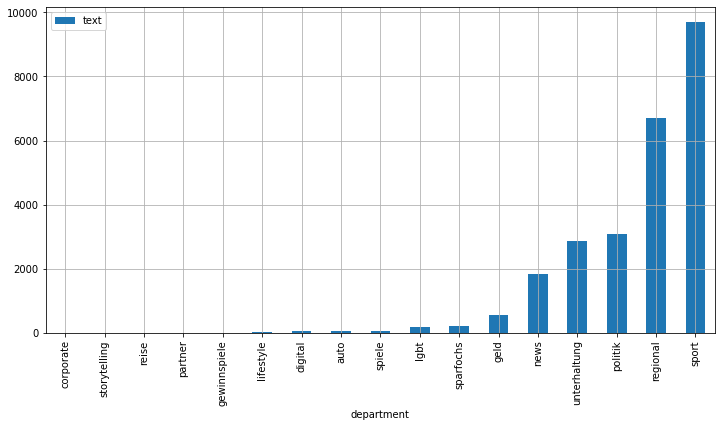

In [79]:
ax= d.groupby('department')["text"].count().sort_values().plot(kind='bar',figsize=(12,6),legend=True,grid=True).set_yscale('linear')

In [1]:
from sentence_transformers import SentenceTransformer
from nltk import word_tokenize,sent_tokenize

model = SentenceTransformer('T-Systems-onsite/cross-en-de-roberta-sentence-transformer')
model.tokenizer.tokenize("Ich bin Tomek")

Downloading: 100%|██████████| 391/391 [00:00<00:00, 72.9kB/s]
Downloading: 100%|██████████| 1.10k/1.10k [00:00<00:00, 493kB/s]
Downloading: 100%|██████████| 7.88k/7.88k [00:00<00:00, 3.01MB/s]
Downloading: 100%|██████████| 541/541 [00:00<00:00, 177kB/s]
Downloading: 100%|██████████| 1.11G/1.11G [06:01<00:00, 3.08MB/s]  
Downloading: 100%|██████████| 27.0/27.0 [00:00<00:00, 12.7kB/s]
Downloading: 100%|██████████| 5.07M/5.07M [00:07<00:00, 723kB/s] 
Downloading: 100%|██████████| 188/188 [00:00<00:00, 104kB/s]


['▁Ich', '▁bin', '▁Tom', 'ek']

In [26]:
w=d.text.apply(lambda x: len(word_tokenize(x))).describe()
sen=d.text.apply(lambda x: len(sent_tokenize(x))).describe()
s=d.text.apply(lambda x: len(model.tokenizer.tokenize(x))).describe()
## Merge and change columns
ditr = pd.concat([s,sen,w],axis=1).drop("count")
ditr.columns= ["#Tokens","#Sentences","#Words"]

#Print table

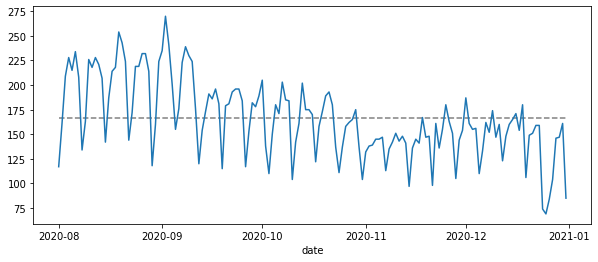

In [146]:
d['date']=d.created_at.dt.date

ax=d[["cms_id","date"]].groupby("date").count().plot(figsize=(10,4),legend=False)

ax.hlines(d[["cms_id","date"]].groupby("date").count().values.reshape(1,-1).mean(), d.date.min(), d.date.max(), linestyles='dashed',color='grey',label="Mean")
plt.show()

In [145]:
d

,cms_id,text,headline,seo_title,created_at,kicker_headline_NER,seo_title_NER,text_NER,department,date
article_uid,,,,,,,,,,
de85c32c6a967eefb65f8227e327e483ae5e67e5108316e4b4e091114df7e7ae,74696338,Er predigte Wasser und trank Wein – jetzt ist ...,Kanada-Minister stolpert über dreistes Fake-Foto,Kanada: Politiker urlaubt in der Karibik – und...,2020-12-31 21:54:16,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",politik,2020-12-31
907f599c809035ae95bdcfa112fc9dd1e3ddd4abafcb7c731a0823d0460b7ae5,74635114,Ein neues Jahr steht vor der Tür und damit auc...,Die besten Sex-Vorsätze fürs neue Jahr,"Mehr, länger, besser!: Die besten Sex-Vorsätze...",2020-12-31 21:40:16,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",unterhaltung,2020-12-31
fb9c6f64e2100f8dea898a1426f67c461bd5b0a78c9eec31d8f51b875e21169c,74693642,Die Vierschanzentournee gehört zu den größten ...,Das verdient man bei der Vierschanzentournee,Vierschanzentournee: Das verdient man beim Ski...,2020-12-31 21:24:15,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",sport,2020-12-31
2de14c75f7c8f82b04e507f02bcfdb5ce2f02aa39cc61b72f1d156820055b949,74695088,Zum Abschluss des Jahres liefert die Formel 1 ...,Weniger Trainingfür Mick,Formel 1: Freies Training für Mick Schumacher ...,2020-12-31 21:15:15,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",sport,2020-12-31
58a58c173b4b6ec885b1a9baf306dd3a65a278788664f44348689f9a80f0c132,74687684,Miau!? Die hinreißende Stieftochter von Uschi ...,Sophie Hermann erklärtihr Nackt-Posting,Sophie Hermann: Stieftochter von Uschi Glas er...,2020-12-31 20:04:15,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",unterhaltung,2020-12-31
...,...,...,...,...,...,...,...,...,...,...
d3e66eb4ecb1c6484459eda3a22543f9463fe7a758ff0c7a30ffe67bf460062a,72167618,"Er tötete drei Menschen, mehr als 260 wurden s...",Todesstrafe für Boston-Bomber aufgehoben,Terroranschlag auf Boston Marathon: Todesurtei...,2020-08-01 07:56:09,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",news,2020-08-01
0c6df23deb1483f617ac939a13822ec781d5500f941df71e74e143f0cdd2bd1a,72163508,Der Vertrag mit Ersatz-Torwart Korbinian Mülle...,Smarsch kommt von Hertha,FC St. Pauli: Neuer Torwart - Dennis Smarsch k...,2020-08-01 07:11:08,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",sport,2020-08-01
8d4f7fc2aaf62468474546919faeac57215e64608369febae60c7b3db127e4c5,72167556,Neue Kampfansage von Donald Trump an Peking. U...,Trump will heute TikTok in den USA verbieten,Millionen Teenies sauer - Trump will heute Tik...,2020-08-01 06:18:09,"[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...","[{""entities"":[{""mentions"":[{""text"":{""content"":...",politik,2020-08-01


166.1045751633987

In [43]:
# Avarege daily dispatched orders
mean = d[["cms_id","date"]].groupby("date").count().values.reshape(1,-1).mean()
# Average daily 
count_daily = df_date.count()['PH_SORDER']
# define figure
fig, ax = plt.subplots(1, figsize=(12,6))
# plot
plt.scatter(count_daily.index, count_daily.values, alpha=0.6)
plt.plot(count_daily.index, [mean]*len(count_daily), 
         color='black', linewidth=2, linestyle='--')
plt.show()

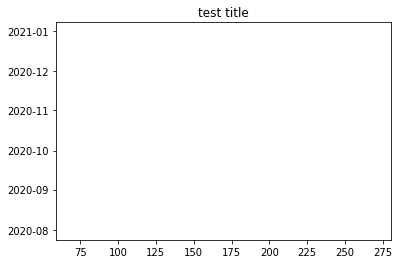

In [120]:
d[["cms_id","date"]].groupby("date").count().values.reshape(1,-1)

array([[117, 161, 209, 228, 215, 234, 208, 134, 163, 226, 218, 228, 221,
        207, 142, 187, 214, 218, 254, 243, 224, 144, 172, 219, 219, 232,
        232, 214, 118, 160, 224, 235, 270, 241, 201, 155, 176, 223, 239,
        230, 224, 176, 120, 154, 173, 191, 186, 196, 181, 115, 179, 181,
        193, 196, 196, 184, 117, 153, 182, 178, 189, 205, 138, 110, 150,
        180, 171, 203, 185, 184, 104, 142, 161, 202, 175, 175, 170, 122,
        158, 173, 189, 193, 180, 137, 111, 137, 158, 162, 165, 175, 137,
        104, 132, 138, 139, 145, 145, 147, 113, 135, 142, 151, 143, 148,
        141,  97, 136, 145, 141, 167, 147, 148,  98, 161, 136, 155, 180,
        163, 151, 105, 144, 154, 187, 161, 155, 156, 110, 133, 162, 152,
        174, 147, 160, 123, 148, 160, 165, 171, 154, 180, 106, 149, 151,
        159, 159,  74,  69,  84, 104, 146, 147, 161,  85]])